### Data Preprocessing

Here we do the data processing. Eevey image is shaped in the dimention (128, 128, 3) here. ```hm``` holds the hashmap in the (key, value) pair in the order of (image, class).

In [68]:
import os
#CHANGE THIS to aboslute path of Caltech repo
os.chdir('C:/Users/proti/')
#this is a global variable to set how many subset of classes we will work with 
#CHANGE THIS TO REQUIRED NUMBER (257) while running on GPU
working_classes = 257

```shrink_square``` takes an image and produces a square image

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image


#images are in different shapes. needs to square them.
def shrink_square(img, shrink_size, color_mode, fill_color):
    #all the images will be shrinked to shrink_size with any leftover filled with color_fill
    ## thumbnail resizes image while maintaining aspect ratio
    shrinked_img=img.thumbnail((shrink_size,shrink_size),Image.ANTIALIAS)
    
    #if some images were originally less than shrink_size, bring to shrink size by filling the leftover
    output=Image.new(color_mode,(shrink_size,shrink_size),fill_color)
    output.paste(img, (int((shrink_size - img.size[0]) / 2), int((shrink_size - img.size[1]) / 2)))
    
    return output


#turn images to np_array
def image_to_tensors(img):
    arr=np.array(img)
    return arr

In [70]:
#globally setting up the square size that all images will be resized to
img_size=128

In [71]:
hm={}
path='./256_ObjectCategories'
folders=os.listdir(path)


for folder in folders:
    os.chdir(path+'/'+folder)
    image_paths=os.listdir()
    class_images=[]
    for i in image_paths:
        if i[-4:]=='.jpg':
            #print("processing ",i)
            img=Image.open(i)
            shrinked_img=shrink_square(img, img_size, 'RGB', 0)
            img_arr=image_to_tensors(shrinked_img)
            img_arr=img_arr/255 #scaling pixel values to [0,1]
            class_images.append(img_arr)
            img.close()
            shrinked_img.close()
    class_name= folder.split('.')[1]
    hm[class_name]=class_images
    os.chdir('../..')

In [72]:
print("total classes: ", len(hm))
sum=0
flawed=0
class_freqs=[]
for k in hm.keys():
    sum+=len(hm[k])
    class_freqs.append(len(hm[k]))
    for i in hm[k]:
        if i.shape != (img_size,img_size,3):
            flawed+=1
print("total images: ",sum)
print("flawd images: ", flawed)

total classes:  257
total images:  30607
flawd images:  0


### Frequency of images per class categories
The following histogram has the number images in the Y-axis corresponding to each class labeled in the X-axis. Each class has at least 80 images. But some of the classes have disproportionate number of images compared to others. This might effect training capacity for a particular number of classes

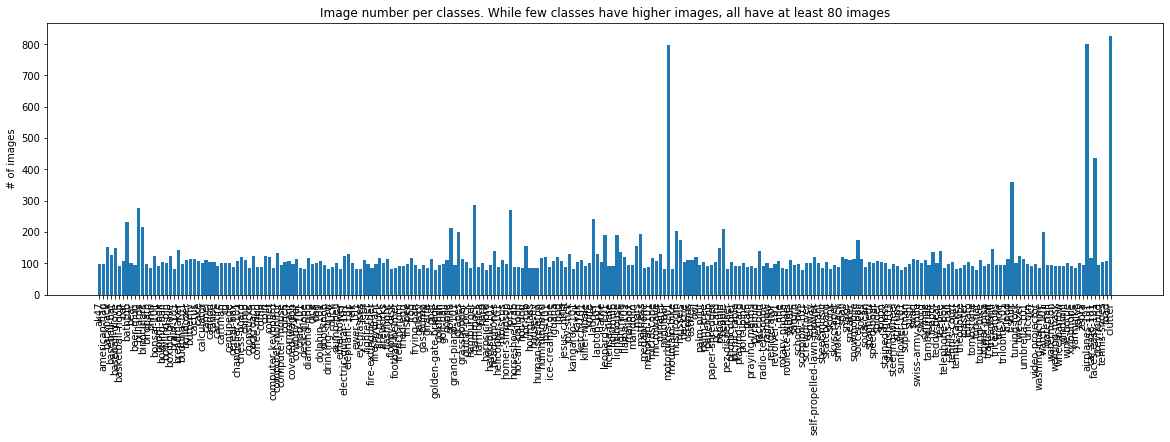

In [73]:
#visualize frequency per class categories
classes=hm.keys()
y_pos=np.arange(len(classes))
plt.figure(figsize=(20,5))
plt.bar(y_pos,class_freqs,align='center', alpha=1)
plt.xticks(y_pos,classes,rotation=90)
plt.ylabel('# of images')
plt.title('Image number per classes. While few classes have higher images, all have at least 80 images')
plt.show()

### Converting Hashmap ```hm``` to (image, class) mapping

The following code maps the images collected in the hashmap ```hm``` that has collected all the square images to (image, class) mapping

In [74]:
#convert hm to X,y data mapping
#where each row of X is an image, y is it's class in int
import random
def make_Xy_Dense(hm,subset_classes):
    classes=list(hm.keys())
    #random.shuffle(classes)
    classes=classes[0:subset_classes]
    X=[]
    y=[]
    for key in classes:
        images=hm[key]
        flatten_images=[]
        for i in images:
            flatten_images.append(i.flatten())
        X.extend(flatten_images)
        y.extend([key]*len(flatten_images))
    X=np.matrix(X)
    y=pd.get_dummies(y)
    
    return X,y

### Making the train:test split

From the first 10 classes, 80% (996 images) have been chosen as training images and the rest 20% (249 images) have been chosen as test images.

In [75]:
X,y=make_Xy_Dense(hm,subset_classes=working_classes)
#make a test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20)

### Converting the images in the shape (128, 128, 3) to pass them to the VGG:


In [76]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = X_train.reshape(-1,img_size,img_size,3)
X_test = X_test.reshape(-1,img_size,img_size,3)

### Applying Data Augmentation Technique

We have to import ```ImageDataGenerator``` class from Keras to do Data Augmentation. An instance of this class is used to augment data to the existing dataset. In the model object of ```Sequential``` model of keras, an instance of this ```ImageDataGenerator``` is passed as an argument. An object of ```ImageDataGenerator``` created with no arguments passed to the constructor (i.e., default constructor) implies that no data aumentation took place. The object has to be instantiated specifically by the user to ensure how many and waht type of modifications the user wants to augment into the data

In [77]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Here we are using a generator with the modifications of range of rotation of 40 degrees, shifting original image within a range of 0.2 times total width, shifting the original image within a range of 0.2 times the total height, a shearing range of 0.2, zooming an image with a range 0.2, and horizontal flip. We do not include vertical flip in data augmentation because that is not the normal orientations of any images in general

In [78]:
generator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Now we import classes from Keras that are needed to build a CNN model. We also initialize the model's total layer, filters in each of the convolution layer of the CNN, learning rates etc.

In [79]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras.backend as K
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D,Flatten

total_layers = 3
filters = 32
learning_rate = .001
epochs = 80
batch_size = 32
decay = learning_rate/epochs
optimizer = Adam(lr=learning_rate,decay=decay)

Now we define a function that takes input the above parameters and returns us a CNN model

In [80]:
def createCNNModel(total_layers, filters, learning_rate, epochs, batch_size, decay, optimizer):
    model = Sequential()
    model.add(Conv2D(filters = (filters), kernel_size= (3,3), input_shape = (img_size,img_size,3), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size = (2,2)))
    print('filter: '+ str(filters))

    for i in range(total_layers):
        fltr = filters * (2**(i+1))
        model.add(Conv2D(filters = fltr, kernel_size= (3,3), padding = 'same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size = (2,2)))
        print('filter: '+ str(filters * (2**(i+1))))

    print('\n')
    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 

    model.add(Dense(257,activation='softmax'))
    model.compile(optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [81]:
model = createCNNModel(total_layers, filters, learning_rate, epochs, batch_size, decay, optimizer)

filter: 32
filter: 64
filter: 128
filter: 256




In the ```fit_generator``` function of model object, we are passing the object created using ```generator.flow()```. The ```flow()``` function of the ```ImageDataGenerator``` class returns an Iterator yielding tuples of ```(x, y)``` where ```x``` is a numpy array of image data (in the case of a single image input) or a list of numpy arrays (in the case with additional inputs) and ```y``` is a numpy array of corresponding labels. 

In [ ]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('C:/Users/proti/MyJupyterNotebooks/Caltech256logDataAugmentation.csv', append=False, separator=',')
from sklearn.metrics import classification_report,confusion_matrix
model.fit_generator(generator.flow(X_train, y_train.values, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=80,
                    verbose=1,
                    validation_data=(X_test, y_test.values),
                    callbacks=[csv_logger])